In [ ]:
## Uncomment the following lines to set up the environment 
#!pip install torch
#!pip install nilearn
#!pip install nibabel
#!pip install pandas
#!pip install sklearn
#!pip install matplotlib
#!pip install numpy
#!pip install torch torchvision
 
!git clone https://gitlab.inria.fr/epione_ML/mcvae.git

In [ ]:
%cd mcvae
!python ./setup.py install

In [2]:
#Google colab: Before running this cell, got to Runtime and select "Restart runtime [Ctrl+M]"

#Binder: Before running this cell, got to Kernel and select "Restart kernel "

import mcvae
print(mcvae.__version__)

2.0.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_decomposition import PLSCanonical, CCA

# Random data generation

Our journey in the analysis of heterogeneous data starts with the generation of synthetic data. We first need to generate multivarite correlated random variables X and Y. To do so, we rely on the generative model we have seen during lesson:

$$ z\sim\mathcal{N}(0,1),$$
$$ X = z w_x,$$
$$ Y = z w_y.$$


In [4]:
# #############################################################################

# N subjects
n = 500
# here we define 2 Gaussian latents variables z = (l_1, l_2)
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)

latents = np.array([l1, l2]).T

# We define two random transformations from the latent space to the space of X and Y respectively
transform_x = np.random.randint(-8,8, size = 10).reshape([2,5])
transform_y = np.random.randint(-8,8, size = 10).reshape([2,5])

# We compute data X = z w_x, and Y = z w_y
X = latents.dot(transform_x) 
Y = latents.dot(transform_y) 

# We add some random Gaussian noise
X = X + 2*np.random.normal(size = n*5).reshape((n, 5))
Y = Y + 2*np.random.normal(size = n*5).reshape((n, 5))


print('The latent space has dimension ' + str(latents.shape))
print('The transformation for X has dimension ' + str(transform_x.shape))
print('The transformation for Y has dimension ' + str(transform_y.shape))

print('X has dimension ' + str(X.shape))
print('Y has dimension ' + str(Y.shape))


The latent space has dimension (500, 2)
The transformation for X has dimension (2, 5)
The transformation for Y has dimension (2, 5)
X has dimension (500, 5)
Y has dimension (500, 5)


[]

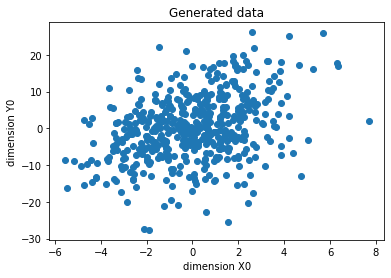

In [5]:
dimension_to_plot = 0

plt.scatter(X[:,1], Y[:,2])
plt.xlabel('dimension X' + str(dimension_to_plot))
plt.ylabel('dimension Y' + str(dimension_to_plot))
plt.title('Generated data')
plt.plot()

## PLS and scikit-learn: basic use


Our newly generated data can be already used to test the PLS and CCA provided by standard machie learning packages, such as scikit-learn.

In [6]:
##########################################################
# We first split the data in trainig and validation sets

# The training set is composed by a random sample of dimension N/2 
train_idx = np.random.choice(range(X.shape[0]), size = int(X.shape[0]/2), replace = False)
X_train = X[train_idx, :]

# The testing set is composed by the remaining subjects
test_idx = np.where(np.in1d(range(X.shape[0]), train_idx, assume_unique =True, invert = True))[0]
X_test = X[test_idx, :]

# We reuse the same indices to split the data Y
Y_train = Y[train_idx, :]
Y_test = Y[test_idx, :]


In [7]:
#######################################
# We fit PLS as provided by scikit-learn

#Defining PLS object
plsca = PLSCanonical(n_components=2)

#Fitting on train data
plsca.fit(X_train, Y_train)

#We project the training data in the latent dimension
X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
#We project the testing data in the latent dimension
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)

We note that the projections in the latent space retrieved by PLS are indeed correlated. The different dimensions of the projections are however uncorrelated. 

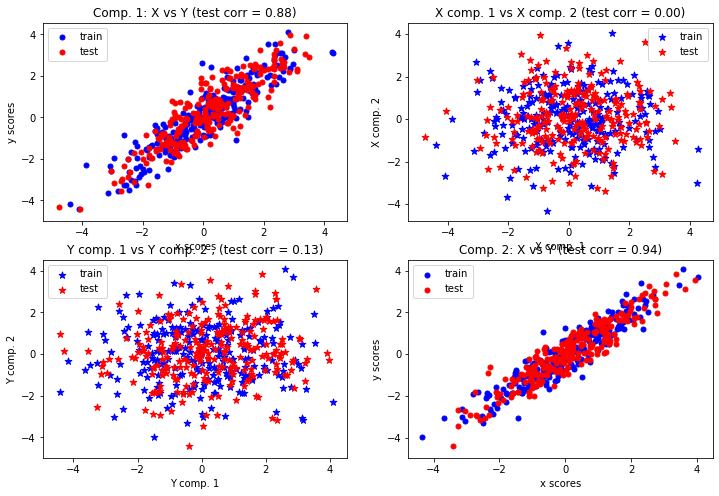

In [8]:
# Scatter plot of scores
# ~~~~~~~~~~~~~~~~~~~~~~
# 1) On diagonal plot X vs Y scores on each components
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])

plt.legend(loc="best")

plt.subplot(224)
plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])

plt.legend(loc="best")

# 2) Off diagonal plot components 1 vs 2 for X and Y
plt.subplot(222)
plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("X comp. 1")
plt.ylabel("X comp. 2")
plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
          % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
plt.legend(loc="best")



plt.subplot(223)
plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("Y comp. 1")
plt.ylabel("Y comp. 2")
plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
          % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
plt.legend(loc="best")

plt.show()


In [9]:
#We can check the estimated projections
print('X projections: \n' + str(plsca.x_weights_))

print('Y projections: \n' + str(plsca.y_weights_))

X projections: 
[[ 0.28300886  0.72235777]
 [-0.37552986 -0.18707255]
 [ 0.65302394  0.03963601]
 [ 0.5466228  -0.29822197]
 [ 0.23161727 -0.59388193]]
Y projections: 
[[ 0.49534889  0.26229067]
 [-0.56101672 -0.12764651]
 [-0.26887931 -0.51792908]
 [ 0.13745828 -0.68753268]
 [-0.59050728  0.41708304]]


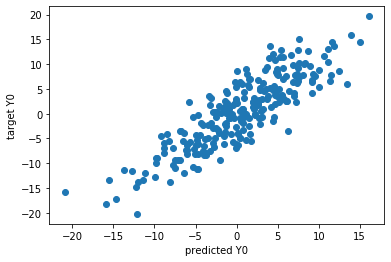

In [10]:
# We can also predict Y from X

predicted_Y_test = plsca.predict(X_test)

plt.scatter(predicted_Y_test[:,dimension_to_plot], Y_test[:,dimension_to_plot])
plt.ylabel('target Y' + str(dimension_to_plot))
plt.xlabel('predicted Y' + str(dimension_to_plot))

plt.show()


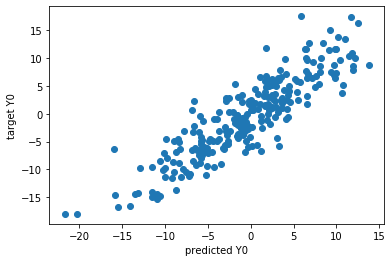

In [11]:
# Prediction for the training data

predicted_Y_train = plsca.predict(X_train)

plt.scatter(predicted_Y_train[:,dimension_to_plot], Y_train[:,dimension_to_plot])
plt.ylabel('target Y' + str(dimension_to_plot))
plt.xlabel('predicted Y' + str(dimension_to_plot))

plt.show()

In [12]:
plsca_4 = PLSCanonical(n_components=4)
plsca_4.fit(X_train, Y_train)

predicted_Y_train = plsca_4.predict(X_train)

print('X projections with 2 components: \n' + str(plsca.x_weights_))

print('Y projections with 2 components: \n' + str(plsca.y_weights_))

print('X projections with 4 components: \n' + str(plsca_4.x_weights_))

print('Y projections with 4 components: \n' + str(plsca_4.y_weights_))


X projections with 2 components: 
[[ 0.28300886  0.72235777]
 [-0.37552986 -0.18707255]
 [ 0.65302394  0.03963601]
 [ 0.5466228  -0.29822197]
 [ 0.23161727 -0.59388193]]
Y projections with 2 components: 
[[ 0.49534889  0.26229067]
 [-0.56101672 -0.12764651]
 [-0.26887931 -0.51792908]
 [ 0.13745828 -0.68753268]
 [-0.59050728  0.41708304]]
X projections with 4 components: 
[[ 0.28300886  0.72235777  0.16471933  0.16950116]
 [-0.37552986 -0.18707255  0.89443104  0.05326543]
 [ 0.65302394  0.03963601  0.36588698 -0.59183235]
 [ 0.5466228  -0.29822197  0.14763938  0.75246248]
 [ 0.23161727 -0.59388193 -0.13111059 -0.22796238]]
Y projections with 4 components: 
[[ 0.49534889  0.26229067 -0.70692449 -0.25602639]
 [-0.56101672 -0.12764651 -0.14033767  0.22177714]
 [-0.26887931 -0.51792908 -0.65870148  0.16303427]
 [ 0.13745828 -0.68753268  0.1812655  -0.6576765 ]
 [-0.59050728  0.41708304 -0.1175512  -0.65279923]]


# Into the guts of latent variable models

After playing with the builti-in implementation of PLS in scikit-learn, we are going to implement our own version based on the NIPALS method.

## NIPALS for PLS

In [13]:
# Nipals method for PLS

n_components = 3


# Defining empty arrays where to store results

# Reconstruction from latent space to data
loading_x = np.ndarray([X.shape[1],n_components])
loading_y = np.ndarray([Y.shape[1],n_components])

# Projections into the latent space
weight_x = np.ndarray([X.shape[1],n_components])
weight_y = np.ndarray([Y.shape[1],n_components])

# Latent variables
scores_x = np.ndarray([X.shape[0],n_components])
scores_y = np.ndarray([Y.shape[0],n_components])


# Initialization of data matrices
current_X = X
current_Y = Y

for i in range(n_components):
    # Initialization of current latent variables as a data column
    t_x = current_X[:,0]

    # NIPALS iterations
    for _ in range(100):
        # estimating Y weights given data Y and latent variables from X
        w_y = current_Y.transpose().dot(t_x)/(t_x.transpose().dot(t_x))
        # normalizing Y weights
        w_y = w_y/np.sqrt(np.sum(w_y**2))

        # estimating latent variables from Y given data Y and Y weights
        t_y = current_Y.dot(w_y)
        # estimating X weights given data X and latent variables from Y
        w_x = current_X.transpose().dot(t_y)/(t_y.transpose().dot(t_y))
        # normalizing X weights
        w_x = w_x/np.sqrt(np.sum(w_x**2))

        # estimating latent variables from X given data X and X weights
        t_x = current_X.dot(w_x)

    # Weights are such that X * weights = t
    weight_x[:,i] = w_x
    weight_y[:,i] = w_y
    
    # Latent variables
    scores_x[:,i] = t_x
    scores_x[:,i] = t_y
    
    # Loadings obtained by regressing X on t (X = t * loadings)
    
    loading_x[:,i] = np.dot(current_X.T, t_x)/t_x.transpose().dot(t_x) 
    loading_y[:,i] = np.dot(current_Y.T, t_y)/t_y.transpose().dot(t_y)
    
    # Deflation = current_data - current_reconstruction
    
    current_X = current_X - t_x.reshape(len(t_x),1).dot(w_x.reshape(1,len(w_x)))
    current_Y = current_Y - t_y.reshape(len(t_y),1).dot(w_y.reshape(1,len(w_y)))
    

In [14]:
print('The estimated projections for X are: \n' + str(weight_x))

print('\n The estimated projections for Y are: \n' + str(weight_y))

The estimated projections for X are: 
[[ 0.70499127  0.584967    0.15742633]
 [-0.00749554 -0.1140001  -0.53840265]
 [-0.09229838  0.43701451  0.23197922]
 [-0.45404349  0.6596544  -0.51225231]
 [-0.53689538  0.13671863  0.60755473]]

 The estimated projections for Y are: 
[[ 0.1534754   0.46121315  0.84583872]
 [-0.06293049 -0.53663536  0.39575359]
 [-0.48254066 -0.42330072  0.34981514]
 [-0.60639499 -0.05687555 -0.0475401 ]
 [ 0.60985628 -0.56292681  0.05749138]]


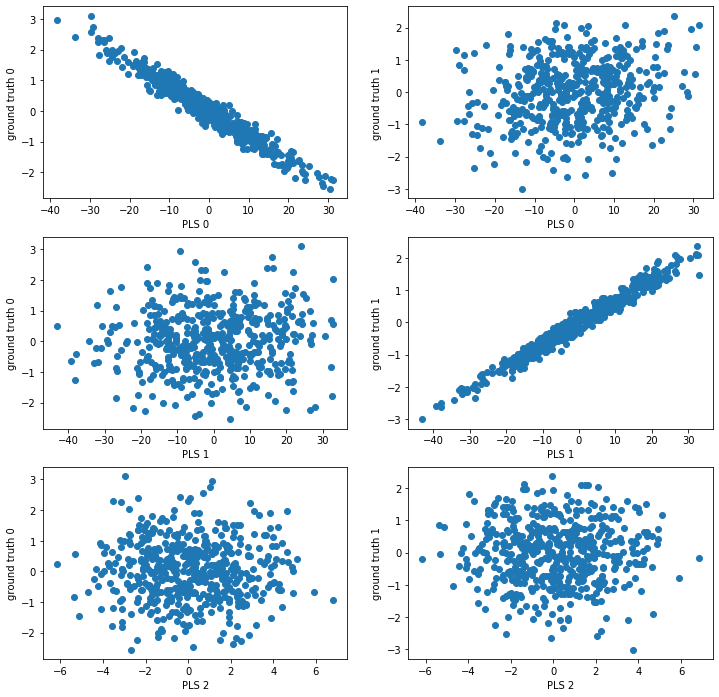

In [15]:
plt.figure(figsize=(12, 12))
plt.subplot(3,2,1)
plt.scatter(scores_x[:,0], latents[:,0])
plt.xlabel('PLS 0')
plt.ylabel('ground truth 0')
plt.subplot(3,2,2)
plt.scatter(scores_x[:,0], latents[:,1])
plt.xlabel('PLS 0')
plt.ylabel('ground truth 1')
plt.subplot(3,2,3)
plt.scatter(scores_x[:,1], latents[:,0])
plt.xlabel('PLS 1')
plt.ylabel('ground truth 0')
plt.subplot(3,2,4)
plt.scatter(scores_x[:,1], latents[:,1])
plt.xlabel('PLS 1')
plt.ylabel('ground truth 1')
plt.subplot(3,2,5)
plt.scatter(scores_x[:,2], latents[:,0])
plt.xlabel('PLS 2')
plt.ylabel('ground truth 0')
plt.subplot(3,2,6)
plt.scatter(scores_x[:,2], latents[:,1])
plt.xlabel('PLS 2')
plt.ylabel('ground truth 1')
plt.show()

Once that the PLS parameters are estimated, we can solve the regression problem for predicting Y from X. We adopt the scheme used in scikit-learn, where a rotation matrix is first estimated to accoung for non-cummutativity between projection (weights) and reconstruction (loadings).



In [16]:
# Identifying rotation from X to t
# t_x * loadings_x = X
# t_x * loadings_x.T * weight = X * weight 
# t_x =  X * weight * (loadings_x.T * weight)^-1 = X * rotations_x

rotations_x = weight_x.dot(np.linalg.pinv(loading_x.T.dot(weight_x)))

# Solving the regression from X to Y
# Y = t_x * loadings_y.T
# Y = X * rotations_x * loadings_y.T

regression_coef = np.dot(rotations_x, loading_y.T)

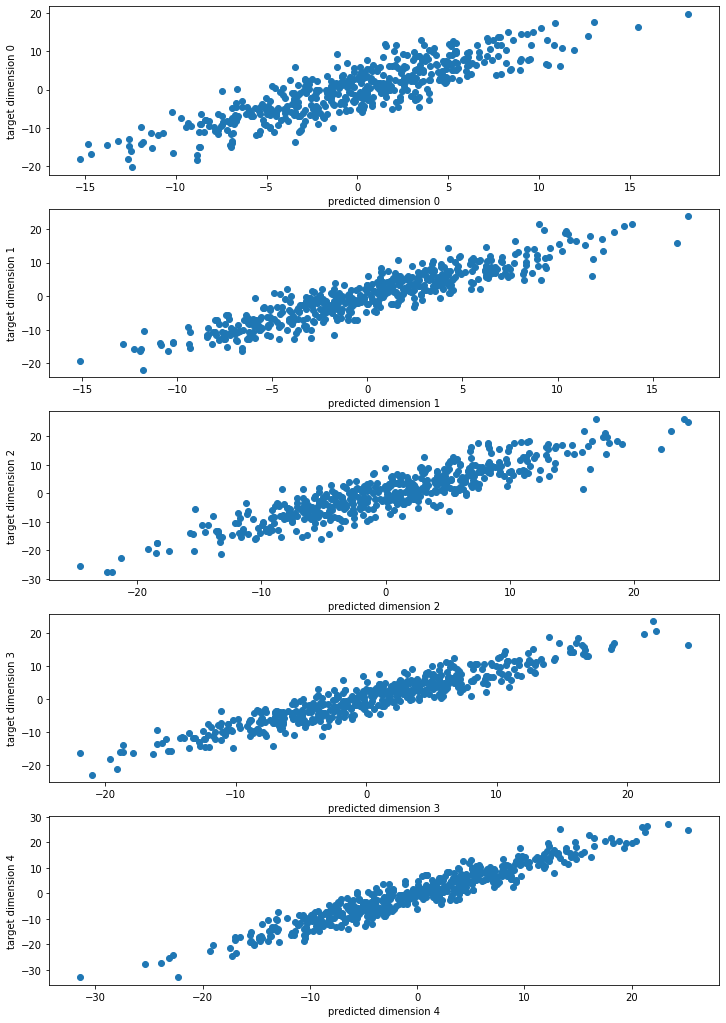

In [17]:
plt.figure(figsize=(12, 18))
for i in range(Y.shape[1]):
  plt.subplot(Y.shape[1], 1, i+1)
  plt.scatter(X.dot(regression_coef)[:,i], Y[:,i])
  plt.xlabel('predicted dimension ' + str(i))
  plt.ylabel('target dimension ' + str(i))
plt.show()

In [18]:
# Comparing with SVD of covariance matrix

eig_val_x, eig_vect, eig_val_y = np.linalg.svd(X.transpose().dot(Y))

In [19]:
print('Eigenvalues for X \n' + str(np.real(eig_val_x[:,:3])))
print('Estimated weights for X\n' + str(np.real(weight_x[:,:3])))

Eigenvalues for X 
[[-0.70499127  0.584967   -0.15742633]
 [ 0.00749554 -0.1140001   0.53840265]
 [ 0.09229838  0.43701451 -0.23197922]
 [ 0.45404349  0.6596544   0.51225231]
 [ 0.53689538  0.13671863 -0.60755473]]
Estimated weights for X
[[ 0.70499127  0.584967    0.15742633]
 [-0.00749554 -0.1140001  -0.53840265]
 [-0.09229838  0.43701451  0.23197922]
 [-0.45404349  0.6596544  -0.51225231]
 [-0.53689538  0.13671863  0.60755473]]


In [20]:
print('Eigenvalues for Y \n' + str(np.real(eig_val_y.T[:,:3])))
print('Estimated weights for Y\n' + str(np.real(weight_y[:,:3])))

Eigenvalues for Y 
[[-0.1534754   0.46121315 -0.84583872]
 [ 0.06293049 -0.53663536 -0.39575359]
 [ 0.48254066 -0.42330072 -0.34981514]
 [ 0.60639499 -0.05687555  0.0475401 ]
 [-0.60985628 -0.56292681 -0.05749138]]
Estimated weights for Y
[[ 0.1534754   0.46121315  0.84583872]
 [-0.06293049 -0.53663536  0.39575359]
 [-0.48254066 -0.42330072  0.34981514]
 [-0.60639499 -0.05687555 -0.0475401 ]
 [ 0.60985628 -0.56292681  0.05749138]]


In [21]:
# PLS in scikit-learn 

plsca = PLSCanonical(n_components=3, scale = False)
plsca.fit(X, Y)

PLSCanonical(n_components=3, scale=False)

In [22]:
print(plsca.x_weights_)
print(plsca.y_weights_)

[[ 0.70465446  0.58526715  0.16259167]
 [-0.00758995 -0.11378745 -0.50337344]
 [-0.09277305  0.43687273  0.24809772]
 [-0.45416309  0.65962298 -0.52347949]
 [-0.53715317  0.13621501  0.62015794]]
[[ 0.15328616  0.46136988  0.8413053 ]
 [-0.06224355 -0.5368113   0.39440975]
 [-0.48217519 -0.42363747  0.36053999]
 [-0.60639039 -0.05733894 -0.06539127]
 [ 0.61026787 -0.56232998  0.04879792]]


## NIPALS for CCA

In [23]:
import scipy

# Nipals method for CCA

# Defining empty arrays where to store results

# Reconstruction from latent space to data
loading_x_cca = np.ndarray([X.shape[1],n_components])
loading_y_cca = np.ndarray([Y.shape[1],n_components])

# Projections into the latent space
scores_x_cca = np.ndarray([X.shape[0],n_components])
scores_y_cca = np.ndarray([Y.shape[0],n_components])

# Latent variables
weight_x_cca = np.ndarray([X.shape[1],n_components])
weight_y_cca = np.ndarray([Y.shape[1],n_components])

# Initialization of data matrices
current_X = X
current_Y = Y

for i in range(n_components):
    # Initialization of current latent variables as a data column
    t_x = current_X[:,0]

    # NIPALS iterations
    for _ in range(500):
        ## CCA variant
        # estimating Y weights given data Y and latent variables from X
        Y_pinv = np.linalg.pinv(current_Y)
        #Y_pinv = np.linalg.solve(current_Y.dot(current_Y.T),current_Y).T
        w_y = Y_pinv.dot(t_x)

        # normalizing Y weights
        w_y = w_y/np.sqrt(np.sum(w_y**2))
        # estimating latent variables from Y given data Y and Y weights
        t_y = current_Y.dot(w_y)

        ## CCA variant
        # estimating X weights given data X and latent variables from Y
        X_pinv = np.linalg.pinv(current_X)
        #X_pinv = np.linalg.solve(current_X.dot(current_X.T),current_X).T
        w_x = X_pinv.dot(t_y)

        # normalizing X weights
        w_x = w_x/np.sqrt(np.sum(w_x**2))
        # estimating latent variables from X given data X and X weights
        t_x = current_X.dot(w_x)

        
    # Weights are such that X * weights = t
    weight_x_cca[:,i] = w_x
    weight_y_cca[:,i] = w_y
    
    # Latent dimensions
    scores_x_cca[:,i] = t_x
    scores_x_cca[:,i] = t_y
    
    # Loadings obtained by regressing X on t (X = t * loadings)
    
    loading_x_cca[:,i] = np.dot(current_X.T, t_x)/t_x.transpose().dot(t_x) 
    loading_y_cca[:,i] = np.dot(current_Y.T, t_y)/t_y.transpose().dot(t_y)
    
    # Deflation = current_data - current_reconstruction

    current_X = current_X - t_x.reshape(len(t_x),1).dot(w_y.reshape(1,len(w_x)))
    current_Y = current_Y - t_y.reshape(len(t_y),1).dot(w_y.reshape(1,len(w_y)))

 


[[ 0.76306116  0.34800481  0.68374912]
 [-0.11578842 -0.13632522 -0.15624608]
 [-0.05146475  0.50425832  0.47702551]
 [-0.43287342  0.72103549  0.52660049]
 [-0.46292838  0.29349525  0.05668235]]


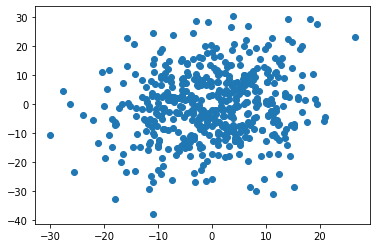

In [24]:
print(weight_x_cca)

plt.scatter(X.dot(weight_x_cca)[:,2], Y.dot(weight_y_cca)[:,2])

[[ 8.11802402e-01  4.21505412e-01  1.27974253e-02]
 [-1.33083389e-01 -1.46835733e-01 -6.01911035e-01]
 [ 2.82710714e-04  5.09363098e-01  1.70315537e-01]
 [-3.60738587e-01  6.89121346e-01 -4.89228432e-01]
 [-4.39469297e-01  2.57746890e-01  6.07608008e-01]]


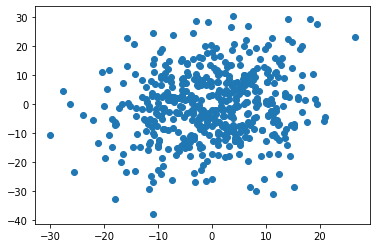

In [25]:
cca = CCA(n_components=3, scale = False)
cca.fit(X,Y)
print(cca.x_weights_)

plt.scatter(X.dot(weight_x_cca)[:,2], Y.dot(weight_y_cca)[:,2])

## Reduced Rank Regression

We finally review reduced rank regression through eigen-decomposition.

In [26]:
# Reduced Rank Regression

n_components = 2
Gamma = np.eye(n_components)

SYX = np.dot(Y.T,X)

SXX = np.dot(X.T,X)

U, S, V = np.linalg.svd(np.dot(SYX, np.dot(np.linalg.pinv(SXX), SYX.T)))

A = V[0:n_components, :].T

B = np.dot(np.dot(A.T,SYX), np.linalg.pinv(SXX))

In [27]:
A

array([[-0.48572511, -0.02464427],
       [ 0.53379126, -0.08304405],
       [ 0.53690548,  0.35165222],
       [ 0.21700363,  0.56905304],
       [ 0.37918327, -0.73825179]])

In [28]:
B

array([[-1.08245089,  0.2792895 , -0.6805486 , -0.70599302, -0.06635519],
       [-0.4557844 ,  0.04299893,  0.21815617,  0.5861077 ,  0.45141095]])

In [29]:
regression_coef_rrr = np.dot(A,B)

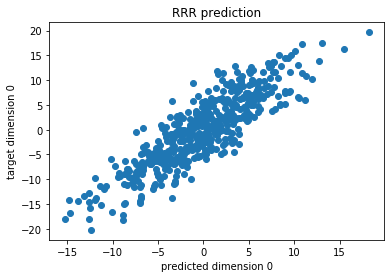

In [30]:
plt.scatter(np.dot(X,regression_coef)[:,0],Y[:,0])
plt.xlabel('predicted dimension 0')
plt.ylabel('target dimension 0')
plt.title('RRR prediction')
plt.show()

## Sparsity in latent variable models

We now focus on the effect of spurious variables in mutivariate models. To explore this new setting, we are going to add spurious random features to our data matrices X and Y.  

In [31]:
## Adding 3 random dimensions
## No association is expected from these features

X_ext = np.hstack([X,np.random.randn(n*3).reshape([n,3])])
Y_ext = np.hstack([Y,np.random.randn(n*3).reshape([n,3])])

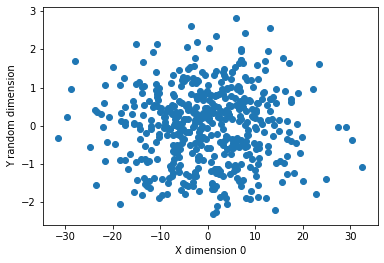

In [32]:
plt.scatter(X_ext[:,0], Y_ext[:,-1])
plt.xlabel('X dimension 0')
plt.ylabel('Y random dimension')
plt.show()

In [33]:
from sklearn import linear_model

n_components = 3

#### Sparse PLS via regularization in NIPALS [Waaijenborg, et al 2007]
# Everything is as for the standard NIPALS algorithm, with the added sparse estimation step   

loading_x_sparse = np.ndarray([X_ext.shape[1],n_components])
loading_y_sparse = np.ndarray([Y_ext.shape[1],n_components])

scores_x_sparse = np.ndarray([X_ext.shape[0],n_components])
scores_y_sparse = np.ndarray([Y_ext.shape[0],n_components])

weight_x_sparse = np.ndarray([X_ext.shape[1],n_components])
weight_y_sparse = np.ndarray([Y_ext.shape[1],n_components])

current_X = X_ext
current_Y = Y_ext

## Penalty parameter for regularization
penalty = 10

eps = 1e-4

for i in range(n_components):
    t_x = current_X[:,0]
    for _ in range(100):
        w_y = current_Y.transpose().dot(t_x)/(t_x.transpose().dot(t_x))
        w_y = w_y/np.sqrt(np.sum(w_y**2))
        t_y = current_Y.dot(w_y)
        w_x = current_X.transpose().dot(t_y)/(t_y.transpose().dot(t_y))
        w_x = w_x/np.sqrt(np.sum(w_x**2))
        t_x = current_X.dot(w_x)
        
        ## Estimating sparse model for the weights of X
        lasso_x = linear_model.Lasso(alpha = penalty)
        lasso_x.fit(t_x.reshape(-1, 1), current_X)
        
        ## Estimating sparse model for the weights of Y
        lasso_y = linear_model.Lasso(alpha = penalty)
        lasso_y.fit(t_y.reshape(-1, 1), current_Y)
        
        # Replacing the original weights with the sparse estimation
        w_x = (lasso_x.coef_ / (np.sqrt(np.sum(lasso_x.coef_**2) + eps))).reshape([X_ext.shape[1]]) 
        w_y = (lasso_y.coef_ / (np.sqrt(np.sum(lasso_y.coef_**2) + eps))).reshape([Y_ext.shape[1]])

    # Weights are such that X * weights = t
    weight_x_sparse[:,i] = w_x
    weight_y_sparse[:,i] = w_y
    
    # Latent dimensions
    scores_x_sparse[:,i] = t_x
    scores_x_sparse[:,i] = t_y
    
    # Loadings obtained by regressing X on t (X = t * loadings)
    
    loading_x_sparse[:,i] = np.dot(current_X.T, t_x)/t_x.transpose().dot(t_x) 
    loading_y_sparse[:,i] = np.dot(current_Y.T, t_y)/t_y.transpose().dot(t_y)
    
    # Deflation
    
    current_X = current_X - t_x.reshape(len(t_x),1).dot(w_x.reshape(1,len(w_x)))
    current_Y = current_Y - t_y.reshape(len(t_y),1).dot(w_y.reshape(1,len(w_y)))
    

We observe that the new weights are similar to the ones estimated before. However the parameters associated with the spurious dimension are entirely set to zero. This indicates that the model does not find these features necessary to explain the common variability between X and Y. There are also other weights which are set to zero, corresponding to the third latent dimension. This makes sense, as our synthetic data was indeed created with only two latent dimensions.

In [34]:
weight_x_sparse

array([[ 0.67332222,  0.59492418, -0.        ],
       [ 0.        , -0.        ,  0.        ],
       [-0.07127568,  0.40874715, -0.        ],
       [-0.49324536,  0.69140624,  0.        ],
       [-0.54602241,  0.02809333, -0.        ],
       [-0.        , -0.        ,  0.        ],
       [-0.        , -0.        ,  0.        ],
       [ 0.        , -0.        , -0.        ]])

In [35]:
weight_y_sparse

array([[ 0.15921169,  0.45664374, -0.        ],
       [-0.06056678, -0.54185977, -0.        ],
       [-0.53238491, -0.41509689, -0.        ],
       [-0.62575264, -0.00755025,  0.        ],
       [ 0.54392181, -0.5704193 ,  0.        ],
       [-0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [-0.        ,  0.        ,  0.        ]])

In [36]:
## Non-sparse parameters previously estimated

weight_x

array([[ 0.70499127,  0.584967  ,  0.15742633],
       [-0.00749554, -0.1140001 , -0.53840265],
       [-0.09229838,  0.43701451,  0.23197922],
       [-0.45404349,  0.6596544 , -0.51225231],
       [-0.53689538,  0.13671863,  0.60755473]])

In [37]:
weight_y

array([[ 0.1534754 ,  0.46121315,  0.84583872],
       [-0.06293049, -0.53663536,  0.39575359],
       [-0.48254066, -0.42330072,  0.34981514],
       [-0.60639499, -0.05687555, -0.0475401 ],
       [ 0.60985628, -0.56292681,  0.05749138]])

In [38]:
## PLS result from scikit-learn PLS on the data augmented with spurious dimensions 

plsca = PLSCanonical(n_components=3, scale = False)
plsca.fit(X_ext, Y_ext)
print(plsca.x_weights_)
print(plsca.y_weights_)

[[ 7.04656457e-01  5.85244854e-01  1.50674413e-01]
 [-7.59099798e-03 -1.13791232e-01 -3.18544905e-01]
 [-9.27665828e-02  4.36873984e-01  2.77831044e-01]
 [-4.54149677e-01  6.59633575e-01 -4.92576077e-01]
 [-5.37145578e-01  1.36221239e-01  5.74337712e-01]
 [-3.96825164e-04 -1.95196678e-03  7.03311056e-02]
 [-3.86465981e-03 -2.05197348e-03 -4.45095215e-01]
 [ 1.90293869e-03  6.61370118e-04  1.51937688e-01]]
[[ 1.53299740e-01  4.61359539e-01  7.70210376e-01]
 [-6.22544676e-02 -5.36797983e-01  2.72254544e-01]
 [-4.82180922e-01 -4.23618461e-01  4.41212713e-01]
 [-6.06391772e-01 -5.73288475e-02 -1.32683569e-01]
 [ 6.10256702e-01 -5.62326590e-01  5.10962222e-02]
 [-6.17622797e-04  5.56475099e-03 -1.47257305e-01]
 [-4.13062446e-04  3.69567447e-03 -1.34213106e-01]
 [ 5.94319237e-04 -5.34204223e-04 -2.79412163e-01]]


## Cross-validating components

In addition to sparsity, the optimal number of components in latent variable models can be identified by cross-validation. 
A common strategy is to train the model on a subset of the data and to quantify the *predicted residual error sum of squares* (PRESS) in non-overlapping testing data. We can finally choose the number of latent dimensions leading to the lowest average PRESS. 

In [39]:
n_cross_valid_run = 200

# number of components to test
n_components = 5

rep_results = [] 
for i in range(n_components):
  rep_results.append([])

for k in range(n_components):
  for i in range(n_cross_valid_run):

    # Sampling disjoint set of indices for splitting the data
    batch1_idx = np.random.choice(range(X_ext.shape[0]), size = int(X_ext.shape[0]/2), replace = False)
    batch2_idx = np.where(np.in1d(range(X_ext.shape[0]), batch1_idx, assume_unique=True, invert = True))[0]

    # Creating independent data batches for X
    X_1 = X_ext[batch1_idx, :]
    X_2 = X_ext[batch2_idx, :]

    # Creating independent data batches for Y
    Y_1 = Y_ext[batch1_idx, :]
    Y_2 = Y_ext[batch2_idx, :]

    # Creating a model for each data batch
    plsca1 = PLSCanonical(n_components = k+1, scale = False)
    plsca2 = PLSCanonical(n_components = k+1, scale = False)

    # Fitting a model for each data batch
    plsca1.fit(X_1,Y_1)
    plsca2.fit(X_2,Y_2)

    # Quantifying the prediction error on the unseen data batch
    err1 = np.sum((plsca1.predict(X_2) - Y_2)**2)
    err2 = np.sum((plsca2.predict(X_1) - Y_1)**2)

    rep_results[k].append(np.mean([err1,err2]))


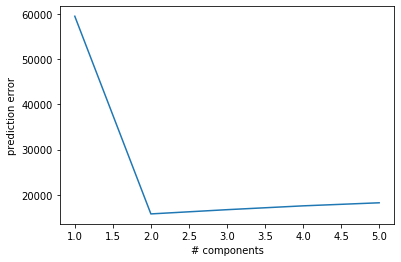

In [40]:
plt.plot(range(1,n_components+1),np.mean(rep_results, 1))
plt.xlabel('# components')
plt.ylabel('prediction error')
plt.show()

# Multi-channel Variational Autoencoder

The last part of this tutorial concerns the use of the *multi-channel variational autoencoder* (https://gitlab.inria.fr/epione_ML/mcvae), a more advanced  methods for the joint analysis and prediction of several modalities.

## VAE
The Variational Autoencoer is a latent variable model composed by one encoder and one decoder associated to a single channel.
The latent distribution $q(\mathbf{z|x})$ and the decoding distribution $p(\mathbf{x|z})$ are Gaussians with moments parametrized by Neural Networks (or a linear transformation layer in a simple case).

Can you find the reason why we use $\log$ values to parametrize the variance (W_logvar)? 

<img src="https://gitlab.inria.fr/epione/flhd/-/raw/master/heterogeneous_data/img/vae.svg" alt="img/vae.svg">

## Sparse VAE
To favour sparsity in the latent space we parametrize the variance of the latent distribution with log_alpha (times $\mu^2)$.

<img src="https://gitlab.inria.fr/epione/flhd/-/raw/master/heterogeneous_data/img/sparse_vae.svg" alt="img/sparse_vae.svg">

## MCVAE
The MultiChannel VAE is built by stacking multiple VAEs and allowing the decoding distributions to be computed from every input channel.

Excercise: sketch the Sparse MCVAE. How many (log) alpha parameters do we need?

<img src="https://gitlab.inria.fr/epione/flhd/-/raw/master/heterogeneous_data/img/mcvae.svg" alt="img/mcvae.svg">


In [41]:
import torch
from mcvae.models import Mcvae
from mcvae.models.utils import DEVICE, load_or_fit
from mcvae.diagnostics import *
from mcvae.plot import lsplom

print(f"Running on {DEVICE}")  # cpu or gpu

FORCE_REFIT = False  # Set this to 'True' if ou want to refit the models instead of loading them from file.

Running on cpu


In [42]:
### To initialization of the mcvae model you should provide:

# 1 - a list with the different data channels
data = [X, Y]
data = [torch.Tensor(_) for _ in data]  #warning: data matrices must be converted to type torch.Tensor

# 1 - a dictionary with the data and model characteristics
init_dict = {
    'data': data,
    'lat_dim': n_components,  
}

In [43]:
# Here we create an instance of the model

adam_lr = 1e-2
n_epochs = 4000

# Multi-Channel VAE
torch.manual_seed(24)
model = Mcvae(**init_dict)
model.to(DEVICE)
print(model)

Mcvae(
  (vae): ModuleList(
    (0): VAE(
      (W_out_logvar): Parameter(shape=torch.Size([1, 5]))
      (W_mu): Linear(in_features=5, out_features=5, bias=True)
      (W_logvar): Linear(in_features=5, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=5, bias=True)
    )
    (1): VAE(
      (W_out_logvar): Parameter(shape=torch.Size([1, 5]))
      (W_mu): Linear(in_features=5, out_features=5, bias=True)
      (W_logvar): Linear(in_features=5, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=5, bias=True)
    )
  )
)


In [44]:
###################
## Model Fitting ##
###################
model.optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)
load_or_fit(model=model, data=data, epochs=n_epochs, ptfile='model.pt', force_fit=FORCE_REFIT)

Loading model.pt


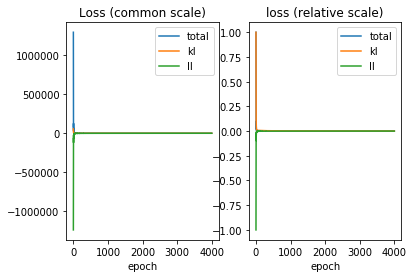

In [45]:
## Plotting model convergence
plot_loss(model)

The plot above indicates that the model converged smoothly.

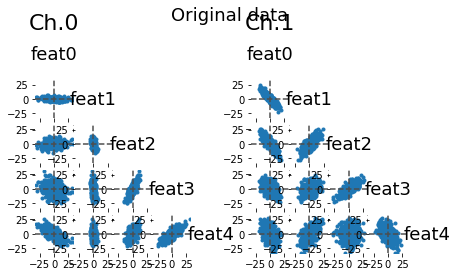

In [46]:
# We can plot the original data, dimension x dimension
lsplom(data, title = 'Original data')

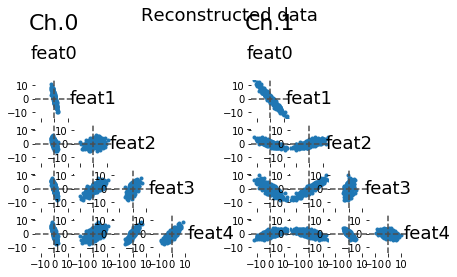

In [47]:
# We can estimate the reconstructed data (decoding from the latent space)
x_hat = model.reconstruct(data)

# Plotting the reconstructed data across dimensions
lsplom(x_hat, title = 'Reconstructed data')

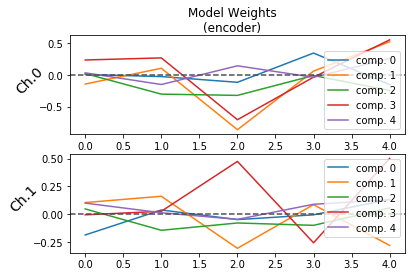

In [48]:
## Plotting the weights of the encoder
plot_weights(model, side = 'encoder')

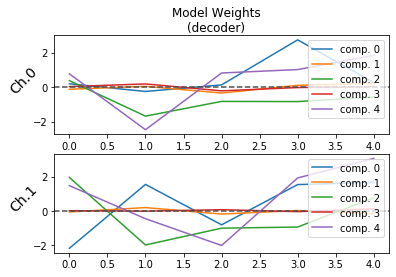

In [49]:
## Plotting the weights of the decoder
plot_weights(model, side = 'decoder')

In [50]:
# Inspecting model parameters

# Decoding parameters
weights_decoding_X = model.vae[0].W_out
weights_decoding_Y = model.vae[1].W_out

In [51]:
weights_decoding_X.weight

Parameter containing:
tensor([[ 0.1979, -0.1202,  0.3788,  0.0346,  0.7717],
        [-0.2494,  0.0462, -1.6802,  0.1872, -2.4670],
        [ 0.1314, -0.3394, -0.8261, -0.2128,  0.8213],
        [ 2.7436,  0.1060, -0.8360, -0.0222,  1.0202],
        [ 0.2645,  0.2223, -0.5717,  0.0332,  1.8429]], requires_grad=True)

In [52]:
weights_decoding_Y.weight

Parameter containing:
tensor([[-2.1793, -0.0622,  1.9454,  0.0123,  1.4728],
        [ 1.5433,  0.1926, -1.9856, -0.0152, -0.4551],
        [-0.8112, -0.1844, -1.0072,  0.0705, -2.0153],
        [ 1.5333,  0.0211, -0.9400, -0.0435,  1.9193],
        [ 1.6573, -0.1743,  0.7618,  0.1178,  3.0549]], requires_grad=True)

In [53]:
# Encoding parameters
weights_encoding_X = model.vae[0].W_mu
weights_encoding_Y = model.vae[1].W_mu

In [54]:
weights_encoding_X.weight

Parameter containing:
tensor([[ 0.0065, -0.0259, -0.1161,  0.3430, -0.1514],
        [-0.1433,  0.1047, -0.8607,  0.0599,  0.5212],
        [ 0.0206, -0.3019, -0.3216, -0.0094, -0.2435],
        [ 0.2345,  0.2672, -0.7037, -0.0358,  0.5507],
        [ 0.0327, -0.1508,  0.1432, -0.0376,  0.2584]], requires_grad=True)

In [55]:
weights_encoding_Y.weight

Parameter containing:
tensor([[-0.1845,  0.0393, -0.0469, -0.0042,  0.1346],
        [ 0.1058,  0.1622, -0.3043,  0.0870, -0.2782],
        [ 0.0486, -0.1427, -0.0772, -0.0984,  0.0575],
        [-0.0042,  0.0276,  0.4748, -0.2548,  0.5010],
        [ 0.1007,  0.0145, -0.0449,  0.0904,  0.1311]], requires_grad=True)

In [56]:
# Here we compute the encoding and plot the latent dimensions against our original ground truth for the syntetic data

encoding = model.encode(data)

encoding_x = encoding[0].loc.detach().numpy()
encoding_y = encoding[1].loc.detach().numpy()

We note that the estimated encoding is correlated with the original latent dimensions. There seems to be however some redundancy. This motivates the use of a *sparse model*.

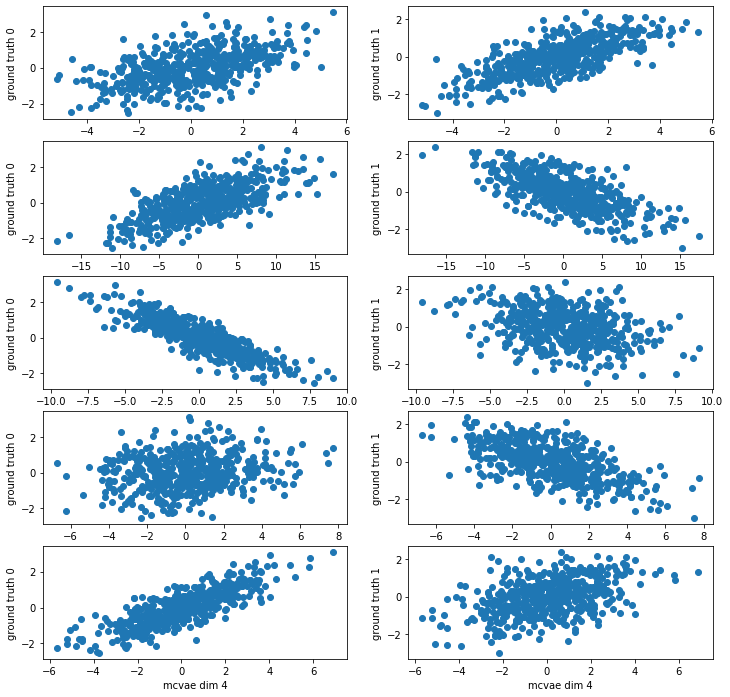

In [57]:
plt.figure(figsize=(12, 12))
for idx,k in enumerate(range(n_components)):
  plt.subplot(n_components,2,2*idx+1)
  plt.scatter(encoding_x[:,k], latents[:,0])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 0')
  plt.subplot(n_components,2,2*idx+2)
  plt.scatter(encoding_x[:,k], latents[:,1])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 1')
plt.show()

In [58]:
# Calling sparse mcvae

adam_lr = 1e-2
n_epochs = 4000

model_sparse1 = Mcvae(sparse=True, **init_dict)
model_sparse1.to(DEVICE)
print(model_sparse1)

print('Is the log_alpha parameter the same for every channel?')
log_alpha = model_sparse1.vae[0].log_alpha
print(np.all([log_alpha is vae.log_alpha for vae in model_sparse1.vae]))

Mcvae(
  (vae): ModuleList(
    (0): VAE(
      (W_out_logvar): Parameter(shape=torch.Size([1, 5]))
      (log_alpha): Parameter(shape=torch.Size([1, 5]))
      (W_mu): Linear(in_features=5, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=5, bias=True)
    )
    (1): VAE(
      (W_out_logvar): Parameter(shape=torch.Size([1, 5]))
      (log_alpha): Parameter(shape=torch.Size([1, 5]))
      (W_mu): Linear(in_features=5, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=5, bias=True)
    )
  )
)
Is the log_alpha parameter the same for every channel?
True


In [59]:
model_sparse1.optimizer = torch.optim.Adam(model_sparse1.parameters(), lr=adam_lr)
load_or_fit(model=model_sparse1, data=data, epochs=n_epochs, ptfile='model_sparse1.pt', force_fit=FORCE_REFIT)

Loading model_sparse1.pt


The sparse model estimates a probability of redundancy associated to each dimension. This means that we can retain only the dimensions with low probability of redundancy. In this case the model correctly identifies only 2 meaningful latent dimensions. 

Probability of redundancy:  [[0.32249367 0.00835145 0.2851929  0.00992655 0.14232847]]


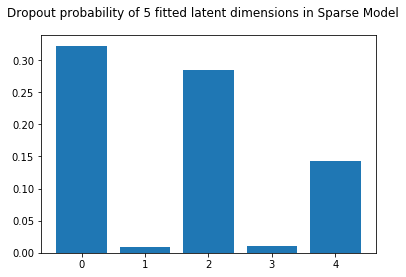

In [60]:
print('Probability of redundancy: ', model_sparse1.dropout.detach().numpy())
plot_dropout(model_sparse1, sort=False)

In [61]:
# We fix a redundancy threshold
dropout_threshold = 0.10

kept components: [1, 3]


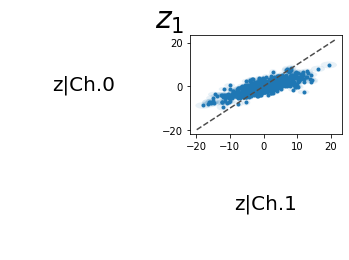

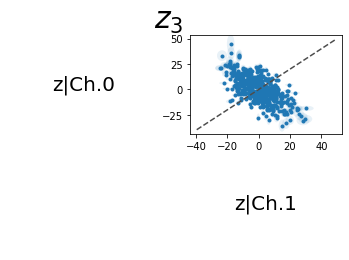

In [62]:
# We plot the remaining latent dimensions
keep = (model_sparse1.dropout.squeeze() < dropout_threshold).tolist()
kept_comps = [i for i, kept in enumerate(keep) if kept]
print(f'kept components: {kept_comps}')

plot_latent_space(model_sparse1, data=data, comp=kept_comps);

In [63]:
# We repeate the same exercise with the synthetic data with redundant dimensions

data_sparse = []
data_sparse.append(torch.FloatTensor(X_ext))
data_sparse.append(torch.FloatTensor(Y_ext))

init_dict = {
    'data': data_sparse,
    'lat_dim': n_components + 3,
}

model_sparse = Mcvae(sparse=True, **init_dict)
model_sparse.to(DEVICE)
print(model_sparse)

Mcvae(
  (vae): ModuleList(
    (0): VAE(
      (W_out_logvar): Parameter(shape=torch.Size([1, 8]))
      (log_alpha): Parameter(shape=torch.Size([1, 8]))
      (W_mu): Linear(in_features=8, out_features=8, bias=True)
      (W_out): Linear(in_features=8, out_features=8, bias=True)
    )
    (1): VAE(
      (W_out_logvar): Parameter(shape=torch.Size([1, 8]))
      (log_alpha): Parameter(shape=torch.Size([1, 8]))
      (W_mu): Linear(in_features=8, out_features=8, bias=True)
      (W_out): Linear(in_features=8, out_features=8, bias=True)
    )
  )
)


In [64]:
# Fit (or load model if existing)
model_sparse.optimizer = torch.optim.Adam(model_sparse.parameters(), lr=adam_lr)
load_or_fit(model=model_sparse, data=data_sparse, epochs=n_epochs, ptfile='model_sparse.pt', force_fit=FORCE_REFIT)

Loading model_sparse.pt


We see that the model recognises again only two meaningful latent dimensions

Probability of redundancy:  [[0.79006654 0.03974237 0.50763535 0.48295972 0.41965452 0.01760831
  0.0222356  0.4364762 ]]
Non-redundant components: [1, 5, 6]


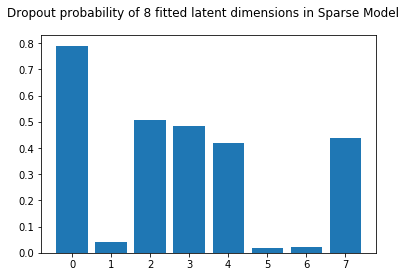

In [65]:
print('Probability of redundancy: ', model_sparse.dropout.detach().numpy())
indices = np.where(model_sparse.dropout.detach().numpy().flatten() < 0.2)[0]
non_redundant_comps = indices.tolist()
print(f'Non-redundant components: {non_redundant_comps}')
plot_dropout(model_sparse, sort=False)

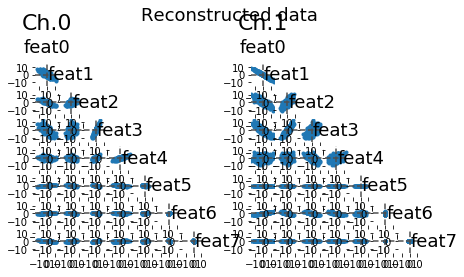

In [66]:
x_hat = model_sparse.reconstruct(data_sparse, dropout_threshold=0.2)
lsplom(x_hat, title = 'Reconstructed data')

<Figure size 864x576 with 0 Axes>

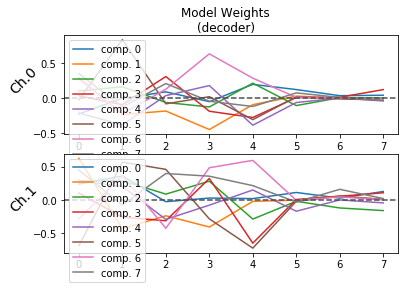

In [67]:
## Plotting the weights of the decoder
plt.figure(figsize=(12, 8))
plot_weights(model_sparse, side = 'decoder')

<Figure size 864x576 with 0 Axes>

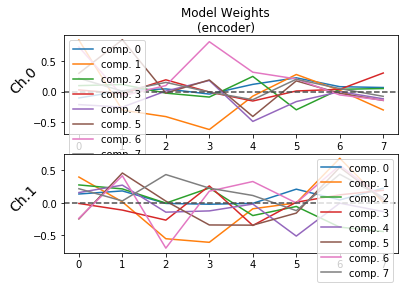

In [68]:
plt.figure(figsize=(12, 8))
plot_weights(model_sparse, side = 'encoder')

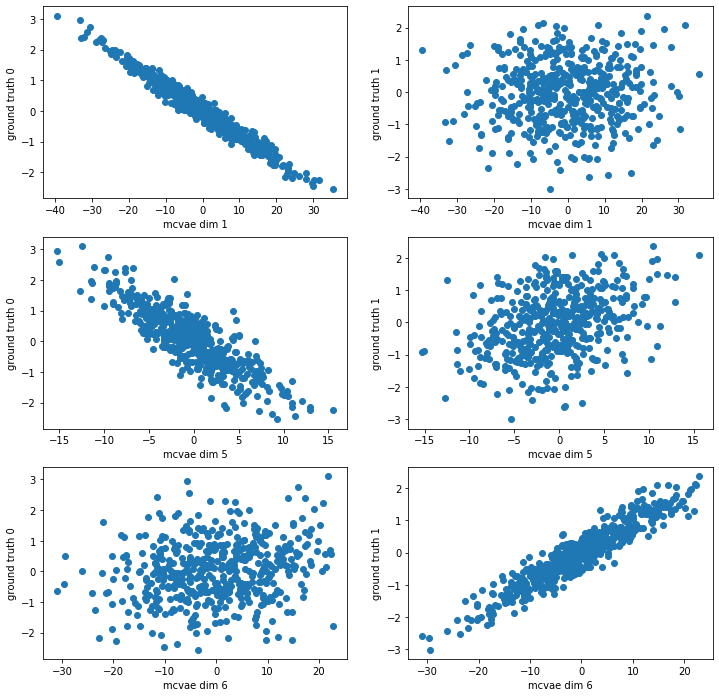

In [69]:
# PLotting estimated encoding vs ground truth

encoding = model_sparse.encode(data_sparse)

encoding_x = encoding[0].loc.detach().numpy()
encoding_y = encoding[1].loc.detach().numpy()

plt.figure(figsize=(12, 12))
for idx,k in enumerate(indices):
  plt.subplot(len(indices),2,2*idx+1)
  plt.scatter(encoding_x[:,k], latents[:,0])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 0')
  plt.subplot(len(indices),2,2*idx+2)
  plt.scatter(encoding_x[:,k], latents[:,1])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 1')

plt.show()

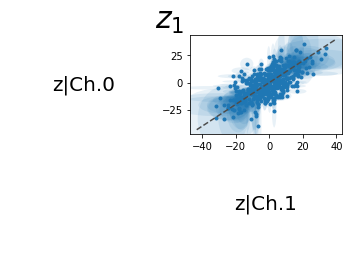

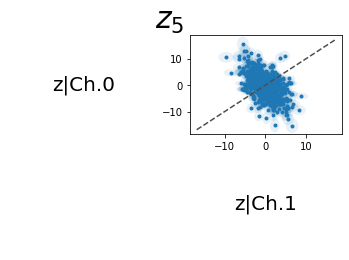

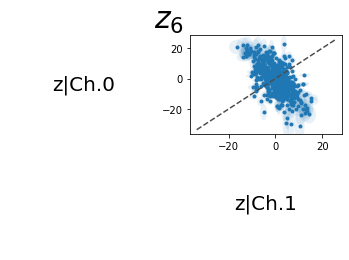

In [70]:
plot_latent_space(model_sparse, data_sparse, comp=non_redundant_comps);

### Increasing the number of channels

In this section we explore the use of the model on data with multiple modalities (or channels)

In [71]:
# generating a new modality z
# This modality has meaningful as well as redundant dimensions

size_z = 10
size_z_redundant = 4

transform_z = np.random.randint(-8,8, size = 2*size_z).reshape([2,size_z])

Z = latents.dot(transform_z) + 2*np.random.normal(size = n*size_z).reshape((n, size_z))
Z = np.hstack([Z,np.random.randn(n*size_z_redundant).reshape([n,size_z_redundant])])

In [72]:
print(X_ext.shape,Y_ext.shape, Z.shape)

(500, 8) (500, 8) (500, 14)


In [73]:
data_multi = []
data_multi.append(torch.FloatTensor(X_ext))
data_multi.append(torch.FloatTensor(Y_ext))
data_multi.append(torch.FloatTensor(Z))

init_dict = {
    'data': data_multi, # [X, Y, Z]
    'lat_dim': n_components + 3,
}

adam_lr = 1e-2
n_epochs = 4000

model_multi = Mcvae(sparse=True, **init_dict)
model_multi.to(DEVICE)
print(model_multi)

Mcvae(
  (vae): ModuleList(
    (0): VAE(
      (W_out_logvar): Parameter(shape=torch.Size([1, 8]))
      (log_alpha): Parameter(shape=torch.Size([1, 8]))
      (W_mu): Linear(in_features=8, out_features=8, bias=True)
      (W_out): Linear(in_features=8, out_features=8, bias=True)
    )
    (1): VAE(
      (W_out_logvar): Parameter(shape=torch.Size([1, 8]))
      (log_alpha): Parameter(shape=torch.Size([1, 8]))
      (W_mu): Linear(in_features=8, out_features=8, bias=True)
      (W_out): Linear(in_features=8, out_features=8, bias=True)
    )
    (2): VAE(
      (W_out_logvar): Parameter(shape=torch.Size([1, 14]))
      (log_alpha): Parameter(shape=torch.Size([1, 8]))
      (W_mu): Linear(in_features=14, out_features=8, bias=True)
      (W_out): Linear(in_features=8, out_features=14, bias=True)
    )
  )
)


In [74]:
# Fit (or load)
model_multi.optimizer = torch.optim.Adam(model_multi.parameters(), lr=adam_lr)
load_or_fit(model=model_multi, data=data_multi, epochs=n_epochs, ptfile='model_multi.pt', force_fit=FORCE_REFIT)

Loading model_multi.pt


Probability of redundancy:  [[0.03612971 0.00668859 0.44017437 0.26902193 0.5011314  0.2900079
  0.49102384 0.5138418 ]]
Non-redundant components:  [0 1]


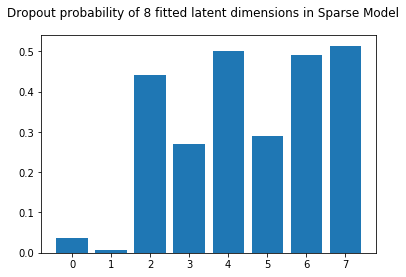

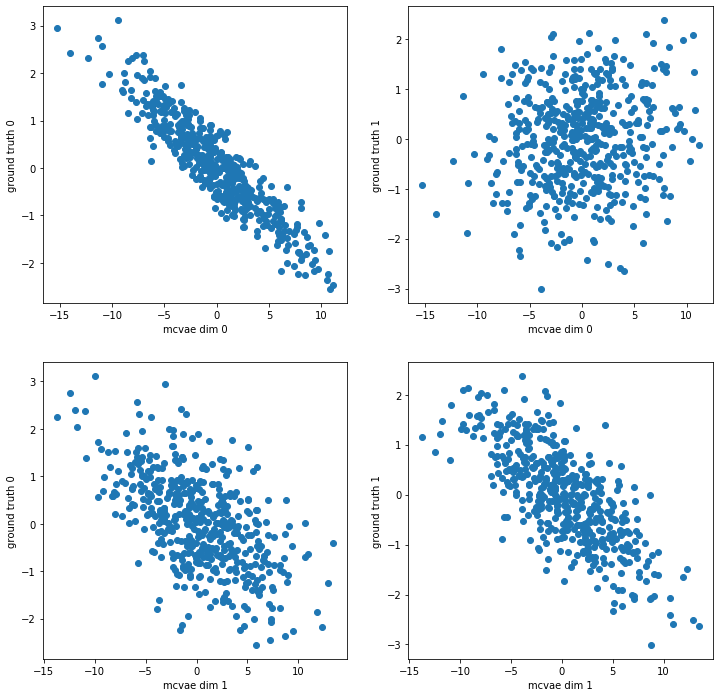

In [75]:
print('Probability of redundancy: ', model_multi.dropout.detach().numpy())
indices = np.where(model_multi.dropout.detach().numpy().flatten() < 0.2)[0]
print('Non-redundant components: ', indices)
plot_dropout(model_multi, sort=False)

encoding = model_multi.encode(data_multi)

encoding_x = encoding[0].loc.detach().numpy()
encoding_y = encoding[1].loc.detach().numpy()
encoding_z = encoding[2].loc.detach().numpy()

plt.figure(figsize=(12, 12))
for idx,k in enumerate(indices):
    plt.subplot(len(indices),2,2*idx+1)
    plt.scatter(encoding_z[:,k], latents[:,0])
    plt.xlabel(str('mcvae dim ') + str(k))
    plt.ylabel('ground truth 0')
    plt.subplot(len(indices),2,2*idx+2)
    plt.scatter(encoding_z[:,k], latents[:,1])
    plt.xlabel(str('mcvae dim ') + str(k))
    plt.ylabel('ground truth 1')

plt.show()

The multi-channel variational autoencoder allows to predict each channel from any other.

In [76]:
# We compute the reconstruction of the data from the encoding
z = [_.sample() for _ in encoding]
reconstruction = model_multi.decode(z)

# This variable has several dimensions over two indices:
# the first index indicates the modality from which the encoding is done (0:x, 1:y, 3:z, ...) 
# the second index indicates the modality to decode(0:x, 1:y, 3:z, ...)

decoding_x_from_x = reconstruction[0][0].loc.detach().numpy()
decoding_x_from_y = reconstruction[1][0].loc.detach().numpy()
decoding_x_from_z = reconstruction[2][0].loc.detach().numpy()

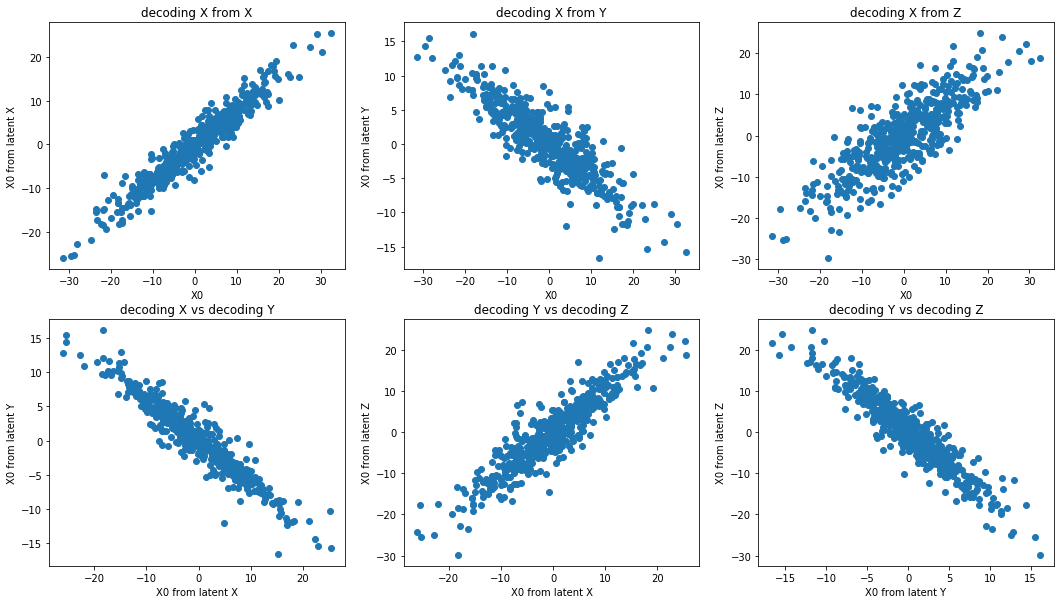

In [77]:
plt.figure(figsize=(18, 10))
plt.subplot(2,3,1)
plt.scatter(X_ext[:,0], decoding_x_from_x[:,0])
plt.title('decoding X from X')
plt.xlabel('X0')
plt.ylabel('X0 from latent X')
plt.subplot(2,3,2)
plt.scatter(X_ext[:,0], decoding_x_from_y[:,0])
plt.title('decoding X from Y')
plt.ylabel('X0 from latent Y')
plt.xlabel('X0')
plt.subplot(2,3,3)
plt.scatter(X_ext[:,0], decoding_x_from_z[:,0])
plt.title('decoding X from Z')
plt.xlabel('X0')
plt.ylabel('X0 from latent Z')
plt.subplot(2,3,4)
plt.scatter(decoding_x_from_x[:,0], decoding_x_from_y[:,0])
plt.title('decoding X vs decoding Y')
plt.xlabel('X0 from latent X')
plt.ylabel('X0 from latent Y')
plt.subplot(2,3,5)
plt.scatter(decoding_x_from_x[:,0], decoding_x_from_z[:,0])
plt.title('decoding Y vs decoding Z')
plt.xlabel('X0 from latent X')
plt.ylabel('X0 from latent Z')
plt.subplot(2,3,6)
plt.scatter(decoding_x_from_y[:,0], decoding_x_from_z[:,0])
plt.title('decoding Y vs decoding Z')
plt.xlabel('X0 from latent Y')
plt.ylabel('X0 from latent Z')
plt.show()

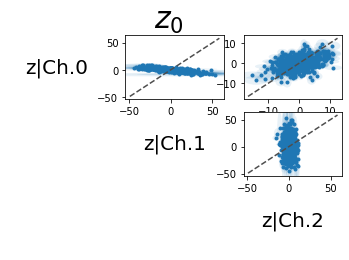

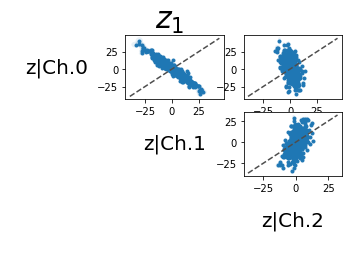

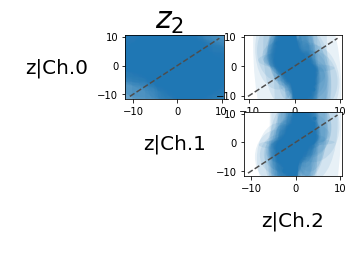

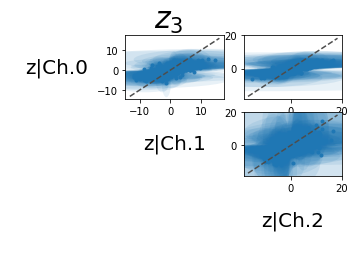

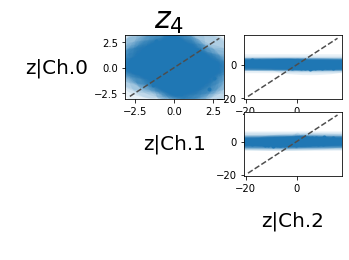

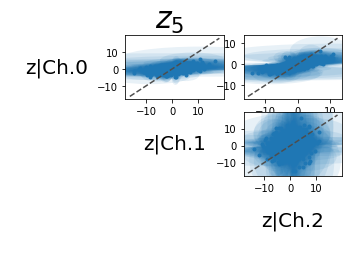

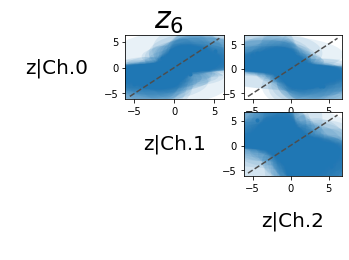

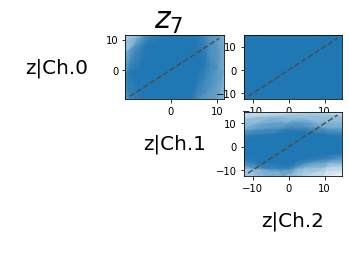

In [78]:
plot_latent_space(model_multi, data_multi);

# Application to (pseudo-) neurological data

We are going to load volumetric and cognitive data for a synthetic sample generated from the ADNI dataset.
The exercise consists in applying the methods seen so far to understand the relationship between this kind of variables.

In [79]:
import pandas as pd

adni = pd.read_csv('https://marcolorenzi.github.io/material/pseudo_adni.csv')

brain_volume_cols = ['WholeBrain.bl', 'Ventricles.bl', 'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']
cognition_cols = ['CDRSB.bl', 'ADAS11.bl', 'MMSE.bl', 'RAVLT.immediate.bl', 'RAVLT.learning.bl', 'RAVLT.forgetting.bl', 'FAQ.bl']

adni[brain_volume_cols]


,WholeBrain.bl,Ventricles.bl,Hippocampus.bl,MidTemp.bl,Entorhinal.bl
0,0.684331,0.012699,0.003786,0.012678,0.002214
1,0.735892,0.012803,0.004866,0.015071,0.003041
2,0.738731,0.030492,0.004300,0.012419,0.002316
3,0.696179,0.032797,0.004720,0.012312,0.002593
4,0.841806,0.004030,0.006820,0.016948,0.002896
...,...,...,...,...,...
995,0.767153,0.011417,0.005209,0.012879,0.002208
996,0.695168,0.011908,0.004641,0.012534,0.002197
997,0.628691,0.041537,0.003478,0.010870,0.001939
998,0.714763,0.020461,0.004713,0.013989,0.001981


In [80]:
volumes_value = adni[brain_volume_cols].values

# Standardization of volumetric measures
volumes_value = (volumes_value - volumes_value.mean(0)) / volumes_value.std(0)

In [81]:
adni[cognition_cols]

,CDRSB.bl,ADAS11.bl,MMSE.bl,RAVLT.immediate.bl,RAVLT.learning.bl,RAVLT.forgetting.bl,FAQ.bl
0,1,8,27.0,23.739439,4.0,5.821573,3
1,0,0,30.0,64.933800,9.0,4.001653,0
2,0,8,24.0,36.987722,3.0,6.876316,0
3,0,3,29.0,50.314425,5.0,4.733481,3
4,0,0,30.0,57.217830,9.0,7.225401,0
...,...,...,...,...,...,...,...
995,1,2,29.0,61.896022,8.0,1.663102,0
996,0,1,29.0,62.083170,8.0,5.241477,1
997,3,14,24.0,22.289059,2.0,5.437600,7
998,0,13,26.0,31.650504,2.0,1.669603,4


In [82]:
cognition_value = adni[cognition_cols].values

# Standardization of cognitive measures
cognition_value = (cognition_value - cognition_value.mean(0)) / cognition_value.std(0)

In [83]:
plsca_adni = PLSCanonical(n_components=3, scale = False)
plsca_adni.fit(cognition_value,volumes_value)
print(plsca_adni.x_weights_)
print(plsca_adni.y_weights_)

[[ 0.38442715 -0.0914859   0.3212761 ]
 [ 0.46751116 -0.13784339  0.29848234]
 [-0.42755384  0.04820369  0.06450696]
 [-0.41248938 -0.01061314  0.43066352]
 [-0.3504303  -0.18746317  0.64581907]
 [ 0.08267813  0.96398703  0.23059686]
 [ 0.38866726 -0.07602536  0.38444838]]
[[-0.38267896  0.49605567  0.326012  ]
 [ 0.30522362 -0.19887222  0.19846392]
 [-0.51586765 -0.39589381  0.68942719]
 [-0.48952454  0.48804833 -0.30834445]
 [-0.5046203  -0.56520397 -0.53286217]]


In [84]:
n_cross_valid_run = 200

# number of components to test
n_components = 5

rep_results = [] 
for i in range(n_components):
  rep_results.append([])

for k in range(n_components):
  for i in range(n_cross_valid_run):

    # Sampling disjoint set of indices for splitting the data
    batch1_idx = np.random.choice(range(cognition_value.shape[0]), size = int(cognition_value.shape[0]/2), replace = False)
    batch2_idx = np.where(np.in1d(range(cognition_value.shape[0]), batch1_idx, assume_unique=True, invert = True))[0]

    # Creating independent data batches for X
    X_1 = cognition_value[batch1_idx, :]
    X_2 = cognition_value[batch2_idx, :]

    # Creating independent data batches for Y
    Y_1 = volumes_value[batch1_idx, :]
    Y_2 = volumes_value[batch2_idx, :]

    # Creating a model for each data batch
    cca_adni1 = CCA(n_components = k+1, scale = False)
    cca_adni2 = CCA(n_components = k+1, scale = False)

    # Fitting a model for each data batch
    cca_adni1.fit(X_1,Y_1)
    cca_adni2.fit(X_2,Y_2)

    # Quantifying the prediction error on the unseen data batch
    err1 = np.sum((cca_adni1.predict(X_2) - Y_2)**2)
    err2 = np.sum((cca_adni2.predict(X_1) - Y_1)**2)

    rep_results[k].append(np.mean([err1,err2]))


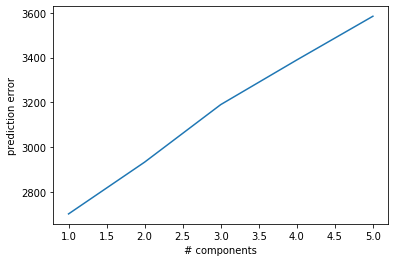

In [85]:
plt.plot(range(1,n_components+1),np.mean(rep_results, 1))
plt.xlabel('# components')
plt.ylabel('prediction error')
plt.show()

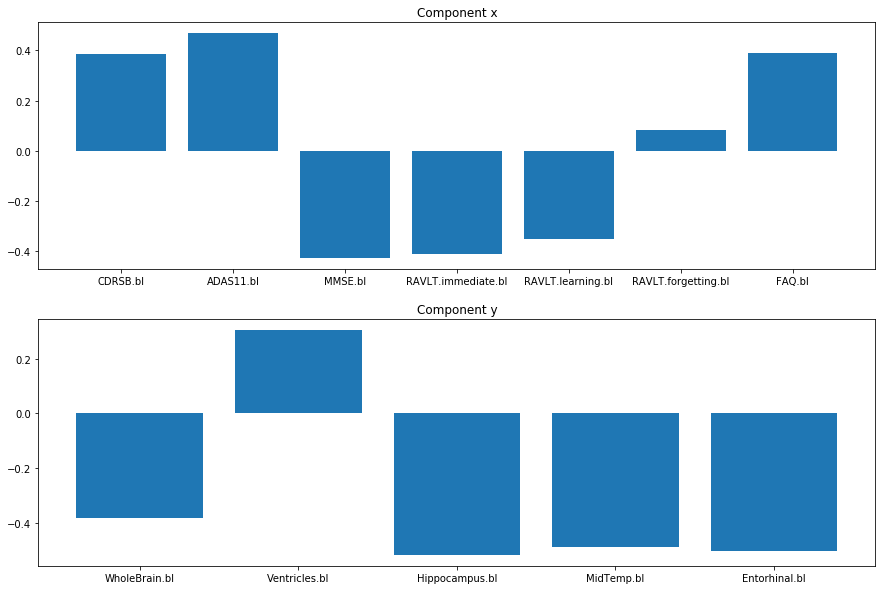

In [86]:
plsca_adni = PLSCanonical(n_components=1, scale = False)
plsca_adni.fit(cognition_value,volumes_value)

f = plt.figure(figsize=(15,10))
f.add_subplot(2,1,1)
plt.bar(np.arange(len(plsca_adni.x_weights_[:,0])), plsca_adni.x_weights_[:,0], tick_label = cognition_cols)
plt.title('Component x')
f.add_subplot(2,1,2)
plt.bar(np.arange(len(plsca_adni.y_weights_[:,0])), plsca_adni.y_weights_[:,0], tick_label = brain_volume_cols)
plt.title('Component y')
plt.show()


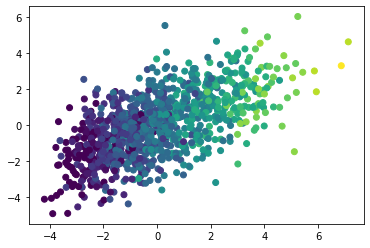

In [87]:
plt.scatter(plsca_adni.x_scores_[:,0], plsca_adni.y_scores_[:,0], c = cognition_value[:,1])
plt.show()

## McVAE

In this last application we apply the multichannel autoencoder to the pseudo-ADNI data, for jointly modeling different modalities across individuals. We focus on the joint analysis of:

- brain volumes;
- sociodemographic information (e.g. age, sex, scholarity); 
- cognition; 
- apoe genotype;
- fluid biomarkers (abeta and tay concentrations in the CSF).

We first import and standardize the different data modalities.

In [88]:
adni = pd.read_csv('https://marcolorenzi.github.io/material/pseudo_adni.csv')

volume_cols = ['WholeBrain.bl', 'Ventricles.bl', 'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']
volumes_value = adni[volume_cols].values

demog_cols = ['SEX', 'AGE', 'PTEDUCAT']
demog_value = adni[demog_cols].values

cognition_cols = ['CDRSB.bl', 'ADAS11.bl', 'MMSE.bl', 'RAVLT.immediate.bl', 'RAVLT.learning.bl', 'RAVLT.forgetting.bl', 'FAQ.bl']
cognition_value = adni[cognition_cols].values

apoe_cols = ['APOE4']
apoe_value = adni[apoe_cols].values

fluid_cols = ['ABETA.MEDIAN.bl', 'PTAU.MEDIAN.bl', 'TAU.MEDIAN.bl']
fluid_value = adni[fluid_cols].values

# Creating a list with multimodal data
data_adni = [volumes_value, demog_value, cognition_value, apoe_value, fluid_value]

# Normalization
data_adni = [(_ - _.mean(0))/_.std(0) for _ in data_adni]

# Transform as a pytorch Tensor for compatibility
data_adni = [torch.Tensor(_) for _ in data_adni]

print(f'We have {len(data_adni)} channels in total as an input for the model')

We have 5 channels in total as an input for the model


In [89]:
# Defining data and model characteristics

init_dict = {
    'data': data_adni,
    'lat_dim': 5, # We fit 5 latent dimensions
}

In [90]:
# Running the model

adam_lr = 1e-2
n_epochs = 6000

model_adni = Mcvae(sparse=True, **init_dict)
model_adni.to(DEVICE)
print(model_adni)

model_adni.optimizer = torch.optim.Adam(model_adni.parameters(), lr=adam_lr)
load_or_fit(model=model_adni, data=data_adni, epochs=n_epochs, ptfile='model_adni.pt', force_fit=FORCE_REFIT)

Mcvae(
  (vae): ModuleList(
    (0): VAE(
      (W_out_logvar): Parameter(shape=torch.Size([1, 5]))
      (log_alpha): Parameter(shape=torch.Size([1, 5]))
      (W_mu): Linear(in_features=5, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=5, bias=True)
    )
    (1): VAE(
      (W_out_logvar): Parameter(shape=torch.Size([1, 3]))
      (log_alpha): Parameter(shape=torch.Size([1, 5]))
      (W_mu): Linear(in_features=3, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=3, bias=True)
    )
    (2): VAE(
      (W_out_logvar): Parameter(shape=torch.Size([1, 7]))
      (log_alpha): Parameter(shape=torch.Size([1, 5]))
      (W_mu): Linear(in_features=7, out_features=5, bias=True)
      (W_out): Linear(in_features=5, out_features=7, bias=True)
    )
    (3): VAE(
      (W_out_logvar): Parameter(shape=torch.Size([1, 1]))
      (log_alpha): Parameter(shape=torch.Size([1, 5]))
      (W_mu): Linear(in_features=1, out_features=5, bias=True)
  

The model identified only a significant dimension, that we are going to store and analyze:

Rendundancy:  [[0.9953835  0.99373364 0.99324256 0.46168032 0.9938754 ]]
Significant dimensions:  [3]


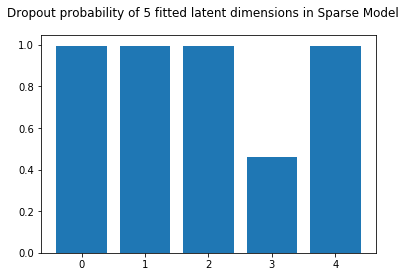

In [91]:
print('Rendundancy: ', model_adni.dropout.detach().numpy())
significant_dim = np.where(model_adni.dropout.detach().numpy()<0.5)[1]
print('Significant dimensions: ', significant_dim)
plot_dropout(model_adni, sort=False)

In [92]:
# Here we store in a list the deconding weights estimated for each modality. 
# We are interested in the decoding weights corresponding to the non-redundant dimension

decoding_weights = []

for i in range(model_adni.n_channels):
    decoding_weights.append(model_adni.vae[i].W_out.weight.detach().numpy()[:, significant_dim[0]])

decoding_weights[0]

array([-0.21898153,  0.17766668, -0.2951996 , -0.25440052, -0.26129985],
      dtype=float32)

In [93]:
# Here we store in a list the deconding weights estimated for each modality. 
# We are interested in the decoding weights corresponding to the non-redundant dimension

decoding_weights = [vae.W_out.weight.data[:, significant_dim[0]] for vae in model_adni.vae]
decoding_weights[0]

tensor([-0.2190,  0.1777, -0.2952, -0.2544, -0.2613])

The weights give us a nice way to interpret how the different modalities interact together.

<BarContainer object of 3 artists>

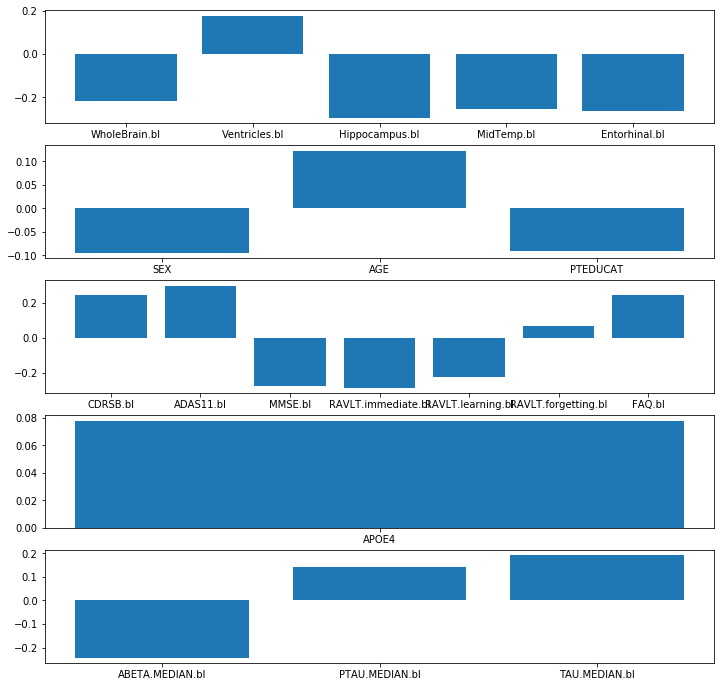

In [94]:
plt.figure(figsize=(12, 12))
plt.subplot(5,1,1)
plt.bar(np.arange(len(decoding_weights[0])), decoding_weights[0], tick_label = volume_cols)
plt.subplot(5,1,2)
plt.bar(np.arange(len(decoding_weights[1])), decoding_weights[1], tick_label = demog_cols)
plt.subplot(5,1,3)
plt.bar(np.arange(len(decoding_weights[2])), decoding_weights[2], tick_label = cognition_cols)
plt.subplot(5,1,4)
plt.bar(np.arange(len(decoding_weights[3])), decoding_weights[3], tick_label = apoe_cols)
plt.subplot(5,1,5)
plt.bar(np.arange(len(decoding_weights[4])), decoding_weights[4], tick_label = fluid_cols)


Once the model is learnt we can use it for prediction. For example we can predict brain volumes from the cognitive data:

In [95]:
# Predicting volumes (channel 0) from cognition (channel 2)
predictions = model_adni.reconstruct(data_adni, reconstruct_from=[2])
decoding_volume_from_cognition = predictions[0].data.numpy()

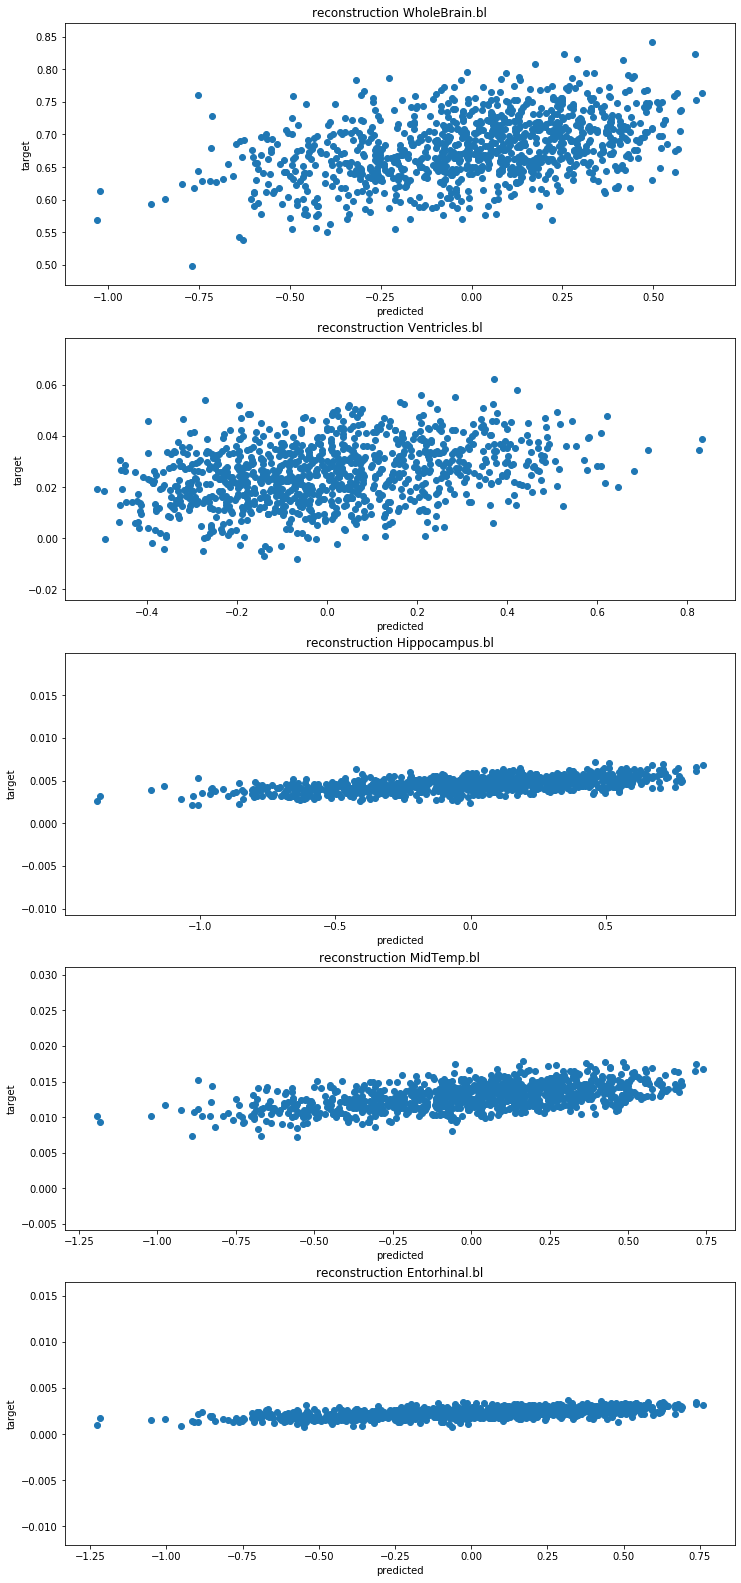

In [96]:
plt.figure(figsize=(12, 28))

# Plotting predictions for each volumetric featurez
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.scatter(decoding_volume_from_cognition[:,i], volumes_value[:,i])
    plt.title('reconstruction ' + volume_cols[i])
    plt.xlabel('predicted')
    plt.ylabel('target')
plt.show()

We are finally going to compare the multichannel model with the standard PLS modeling cognition and brain volumes jointly:

In [97]:
plsca = PLSCanonical(n_components=1, scale = False)
plsca.fit(cognition_value,volumes_value)
print(plsca.x_weights_)
print(plsca.y_weights_)

[[-0.07955857]
 [-0.44864546]
 [ 0.15614821]
 [ 0.82069488]
 [ 0.14575044]
 [ 0.00273618]
 [-0.27058208]]
[[ 0.98002654]
 [-0.19216895]
 [ 0.02203838]
 [ 0.04446817]
 [ 0.01248896]]


We obtain predictions from the PLS model and compare them with the predictions of mcvae. We observe a strong correlation between predictions. However, it can be noted that as we increase the number of dimensions of CCA, the difference between prediction increases, as CCA tends to overfit. 

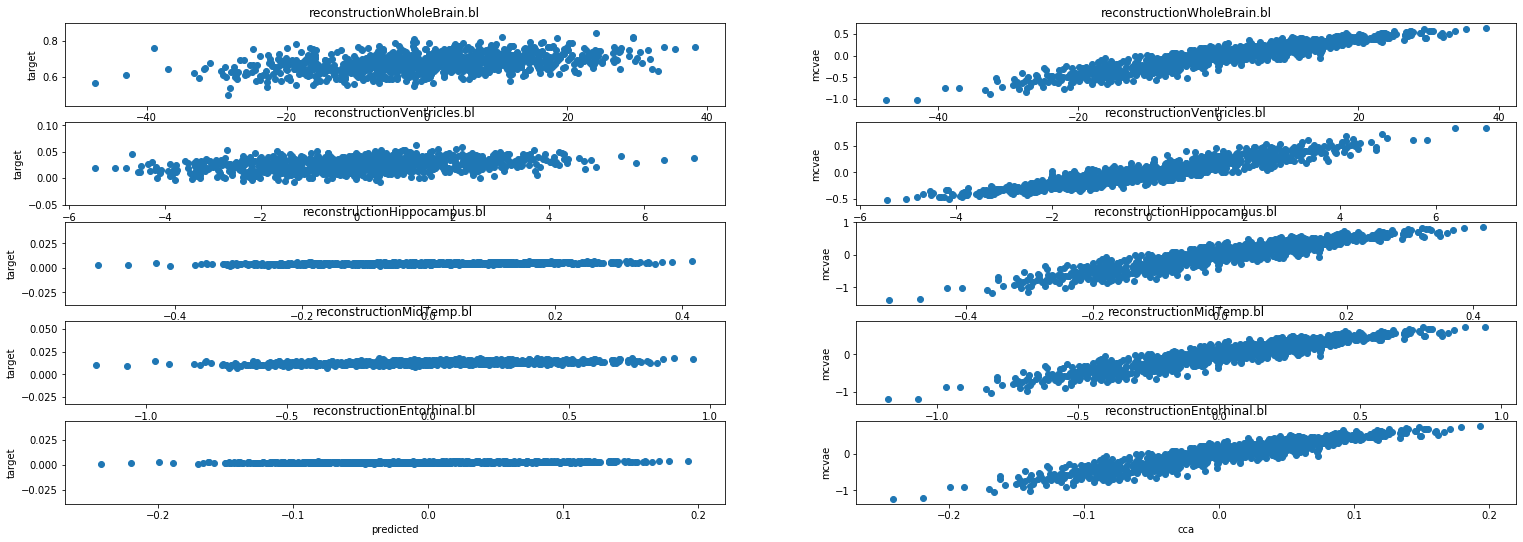

In [98]:
predicted_plsca = plsca.predict(cognition_value)

plt.figure(figsize=(26, 18))

for i in range(5):
    plt.subplot(10,2,2*i+1)
    plt.scatter(predicted_plsca[:,i], volumes_value[:,i])
    plt.title('reconstruction' + volume_cols[i])
    plt.xlabel('predicted')
    plt.ylabel('target')
       
for i in range(5):
    plt.subplot(10,2,2*i+2)
    plt.scatter(predicted_plsca[:,i], decoding_volume_from_cognition[:,i])
    plt.title('reconstruction' + volume_cols[i])
    plt.xlabel('cca')
    plt.ylabel('mcvae')
    
plt.show()

In [99]:
# Comparing average reconstruction errors between models

print('Reconstruction error:')
print(f'CCA: {((predicted_plsca-volumes_value)**2).sum()}')
print(f'mvae: {((decoding_volume_from_cognition-volumes_value)**2).sum()}')

Reconstruction error:
CCA: 179664.0344930744
mvae: 1005.6603667532048


It is interesting to notice that mcvae leads to a lower reconstruction error than CCA, as the prediction of mcvae benefits from training from other modalities as well.